In [1]:
# Limits for how many words can be considered
zh_vocab_size = 30000
en_vocab_size = 30000

# Limits for how long a sequence will be considered
zh_max_len = 200
en_max_len = 200

# Limits for how much of the dataset to load
train_samples = 300000
val_samples = 5000

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import numpy as np
import h5py
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import functools
import re

In [ ]:
work_dir = os.getcwd()
os.chdir("/ibex/scratch/somc")

with h5py.File("zh_train_ds.hdf5", "r") as f:
  zh_train_ds = f["zh_train_ds"][:]
with h5py.File("en_train_ds.hdf5", "r") as f:
  en_train_ds = f["en_train_ds"][:]
with h5py.File("zh_val_ds.hdf5", "r") as f:
  zh_val_ds = f["zh_val_ds"][:]
with h5py.File("en_val_ds.hdf5", "r") as f:
  en_val_ds = f["en_val_ds"][:]
zh_timesteps, en_timesteps = zh_train_ds.shape[1], en_train_ds.shape[1]
training_samples, val_samples = zh_train_ds.shape[0], zh_val_ds.shape[0]
print(f"Chinese training dataset samples: {training_samples}   Chinese training dataset timesteps: {zh_timesteps}")
print(f"English training dataset samples: {training_samples}   English training dataset timesteps: {en_timesteps}")
print(f"Chinese validation dataset samples: {val_samples}   Chinese validation dataset timesteps: {zh_timesteps}")
print(f"English validation dataset samples: {val_samples}   English validation dataset timesteps: {en_timesteps}")

zh_tokenize = tf.keras.models.load_model("zh_tokenize")
en_tokenize = tf.keras.models.load_model("en_tokenize")

zh_train_ds = zh_train_ds[0:train_samples]
en_train_ds = en_train_ds[0:train_samples]
zh_val_ds = zh_val_ds[0:val_samples]
en_val_ds = en_val_ds[0:val_samples]

en_dec_train_ds = np.concatenate((en_train_ds[:, 1:], np.zeros((en_train_ds.shape[0], 1))), axis = 1)
en_dec_val_ds = np.concatenate((en_val_ds[:, 1:], np.zeros((en_val_ds.shape[0], 1))), axis = 1)

os.chdir(work_dir)

In [4]:
# Instead of using separate validation set, use samples from train set instead
zh_train_ds, zh_val_ds, en_train_ds, en_val_ds = train_test_split(zh_train_ds, en_train_ds, test_size = .03)

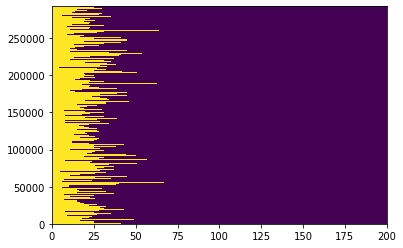

In [4]:
plt.pcolormesh(zh_train_ds != 0)

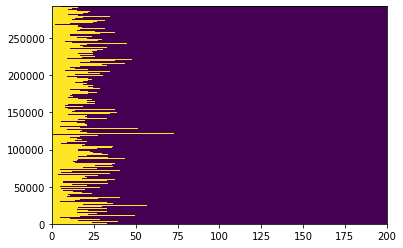

In [ ]:
plt.pcolormesh(en_train_ds != 0)

# **Dataset**

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jieba
import urllib
import h5py

In [ ]:
config = tfds.translate.wmt.WmtConfig(
    version = "1.0.0",
    language_pair = ("zh", "en"),
    subsets = {
        tfds.Split.TRAIN: ["newscommentary_v14"],
        tfds.Split.VALIDATION: ["newstest2018"],
    },
)
builder = tfds.builder("wmt_translate", config = config)
builder.download_and_prepare()
train_ds, val_ds = builder.as_dataset(split = ["train", "validation"], shuffle_files = True, as_supervised = True)

In [ ]:
print(f"Length of training dataset: {len(train_ds)}   Length of validation dataset: {len(val_ds)}")

Length of training dataset: 311556   Length of validation dataset: 3981


In [5]:
with urllib.request.urlopen("https://raw.githubusercontent.com/fxsjy/jieba/master/jieba/dict.txt") as f:
  zh_dictionary = f.readlines()
zh_dictionary = [x.decode("utf8").split(" ", 1)[0] for x in zh_dictionary]

In [ ]:
# Using 结巴 to tockenize Chinese text
# The reason is because Chinese words cannot be delimited easily (as opposed to English with spaces), so we need a smarter library to split text into meaningful words.
# For example, if 北 and 京 were processed as separate words, we would lose the meaning of 北京.  So we need a library to recognize these words.
def get_zh_train_for_tok():
  for i, (en, zh) in enumerate(train_ds):
    cut = jieba.lcut(zh.numpy(), cut_all = False, HMM = True)
    if cut[0] in zh_dictionary:  # Some samples have bad encoding, check here
      zh_sentence = " ".join(cut)
      yield ["<SOS> " + zh_sentence + " <EOS>"]

def get_en_train_for_tok():
  for i, (en, zh) in enumerate(train_ds):
    cut = jieba.lcut(zh.numpy(), cut_all = False, HMM = True)
    if cut[0] in zh_dictionary:  # Some samples have bad encoding, check here
      en_sentence = en.numpy().decode("utf8")
      yield ["<SOS> " + en_sentence + " <EOS>"]

def get_zh_val_for_tok():
  for i, (zh, en) in enumerate(val_ds):
    cut = jieba.lcut(zh.numpy(), cut_all = False, HMM = True)
    if cut[0] in zh_dictionary:  # Some samples have bad encoding, check here
      zh_sentence = " ".join(cut)
      yield ["<SOS> " + zh_sentence + " <EOS>"]

def get_en_val_for_tok():
  for i, (zh, en) in enumerate(val_ds):
    cut = jieba.lcut(zh.numpy(), cut_all = False, HMM = True)
    if cut[0] in zh_dictionary:  # Some samples have bad encoding, check here
      en_sentence = en.numpy().decode("utf8")
      yield ["<SOS> " + en_sentence + " <EOS>"]

zh_train_tok_ds = tf.data.Dataset.from_generator(get_zh_train_for_tok, output_types = tf.string, output_shapes = (1,))
en_train_tok_ds = tf.data.Dataset.from_generator(get_en_train_for_tok, output_types = tf.string, output_shapes = (1,))
zh_val_tok_ds = tf.data.Dataset.from_generator(get_zh_val_for_tok, output_types = tf.string, output_shapes = (1,))
en_val_tok_ds = tf.data.Dataset.from_generator(get_en_val_for_tok, output_types = tf.string, output_shapes = (1,))

In [ ]:
zh_lens = [(str(x.numpy()).count(" ") + 1) for x in zh_train_tok_ds]
print(f"Maximum Chinese sentence length: {max(zh_lens)}   Index of longest sentence: {zh_lens.index(max(zh_lens))}")
en_lens = [(str(x.numpy()).count(" ") + 1) for x in en_train_tok_ds]
print(f"Maximum English sentence length: {max(en_lens)}   Index of longest sentence: {en_lens.index(max(en_lens))}")

Maximum Chinese sentence length: 199   Index of longest sentence: 104552
Maximum English sentence length: 155   Index of longest sentence: 264333


In [ ]:
# Define Chinese tokenizer
zh_vectorize = tf.keras.layers.TextVectorization(
    max_tokens = zh_vocab_size,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = zh_max_len)

zh_vectorize.adapt(zh_train_tok_ds.prefetch(tf.data.AUTOTUNE), batch_size = 4096)
zh_tokenize = tf.keras.models.Sequential()
zh_tokenize.add(tf.keras.Input(shape = (1,), dtype = tf.string))
zh_tokenize.add(zh_vectorize)

# Define English tokenizer
en_vectorize = tf.keras.layers.TextVectorization(
    max_tokens = en_vocab_size,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = en_max_len)

en_vectorize.adapt(en_train_tok_ds.prefetch(tf.data.AUTOTUNE), batch_size = 4096)
en_tokenize = tf.keras.models.Sequential()
en_tokenize.add(tf.keras.Input(shape = (1,), dtype = tf.string))
en_tokenize.add(en_vectorize)

In [ ]:
# Tokenize Chinese training dataset
zh_tokenized = zh_tokenize.predict(zh_train_tok_ds.prefetch(tf.data.AUTOTUNE), batch_size = 4096)
# Tokenize Chinese validation dataset
zh_val_tokenized = zh_tokenize.predict(zh_val_tok_ds.prefetch(tf.data.AUTOTUNE), batch_size = 4096)

# Tokenize English training dataset
en_tokenized = en_tokenize.predict(en_train_tok_ds.prefetch(tf.data.AUTOTUNE), batch_size = 4096)
# Tokenize English validation dataset
en_val_tokenized = en_tokenize.predict(en_val_tok_ds.prefetch(tf.data.AUTOTUNE), batch_size = 4096)

In [ ]:
# Save tokenization layers for later use
zh_tokenize.save("zh_tokenize")
en_tokenize.save("en_tokenize")

In [ ]:
def save_dataset(tokenized, filename):
  tokenized = np.array(tokenized)
  samples = tokenized.shape[0]
  timesteps = tokenized.shape[1]
  print(f"Samples: {samples}   Timesteps: {timesteps}")
  with h5py.File(filename, "w") as f:
    f.create_dataset(filename.split(".")[0], data = tokenized)

save_dataset(zh_tokenized, "zh_train_ds.hdf5")
save_dataset(en_tokenized, "en_train_ds.hdf5")
save_dataset(zh_val_tokenized, "zh_val_ds.hdf5")
save_dataset(en_val_tokenized, "en_val_ds.hdf5")

# **LSTM RNN**

In [8]:
units = 512
embed_units = 512
epochs = 50
batch_size = 1024
target_acc = .9

In [9]:
class LSTMEncoderCell(tf.keras.layers.Layer):

  def __init__(self, units):
    super(LSTMEncoderCell, self).__init__()
    self.units = units
    self.state_size = (units, units)
    self.output_size = units

  def build(self, input_shape):
    self.w_update_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_update_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_update = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_forget_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_forget_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_forget = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_candidate_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_candidate_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_candidate = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_activation_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_activation_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_activation = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.built = True

  def call(self, inputs, states):
    prev_h = states[0]
    prev_c = states[1]

    update = tf.matmul(inputs, self.w_update_x)
    update += tf.matmul(prev_h, self.w_update_h)
    update += self.b_update
    update = tf.keras.activations.sigmoid(update)

    forget = tf.matmul(inputs, self.w_forget_x)
    forget += tf.matmul(prev_h, self.w_forget_h)
    forget += self.b_forget
    forget = tf.keras.activations.sigmoid(forget)

    candidate = tf.matmul(inputs, self.w_candidate_x)
    candidate += tf.matmul(prev_h, self.w_candidate_h)
    candidate += self.b_candidate
    candidate = tf.keras.activations.sigmoid(candidate)

    activation = tf.matmul(inputs, self.w_activation_x)
    activation += tf.matmul(prev_h, self.w_activation_h)
    activation += self.b_activation
    activation = tf.keras.activations.sigmoid(activation)

    c = tf.math.multiply(update, candidate) + tf.math.multiply(forget, prev_c)
    h = tf.math.multiply(activation, tf.keras.activations.sigmoid(c))
    
    return h, [h, c]

class LSTMManyInputDecoderCell(tf.keras.layers.Layer):

  def __init__(self, units, vocab_size):
    super(LSTMManyInputDecoderCell, self).__init__()
    self.units = units
    self.state_size = (units, units)
    self.output_size = units
    self.vocab_size = vocab_size

  def build(self, input_shape):
    self.w_update_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_update_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_update = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_forget_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_forget_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_forget = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_candidate_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_candidate_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_candidate = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_activation_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_activation_h = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_activation = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_softmax = self.add_weight(shape = (self.units, self.vocab_size), initializer = "random_normal", trainable = True)
    self.b_softmax = self.add_weight(shape = (self.vocab_size,), initializer = "random_normal", trainable = True)

    self.built = True

  def call(self, inputs, states):
    prev_h = states[0]
    prev_c = states[1]

    update = tf.matmul(inputs, self.w_update_x)
    update += tf.matmul(prev_h, self.w_update_h)
    update += self.b_update
    update = tf.keras.activations.sigmoid(update)

    forget = tf.matmul(inputs, self.w_forget_x)
    forget += tf.matmul(prev_h, self.w_forget_h)
    forget += self.b_forget
    forget = tf.keras.activations.sigmoid(forget)

    candidate = tf.matmul(inputs, self.w_candidate_x)
    candidate += tf.matmul(prev_h, self.w_candidate_h)
    candidate += self.b_candidate
    candidate = tf.keras.activations.sigmoid(candidate)

    activation = tf.matmul(inputs, self.w_activation_x)
    activation += tf.matmul(prev_h, self.w_activation_h)
    activation += self.b_activation
    activation = tf.keras.activations.sigmoid(activation)

    c = tf.math.multiply(update, candidate) + tf.math.multiply(forget, prev_c)
    h = tf.math.multiply(activation, tf.keras.activations.sigmoid(c))

    y = tf.matmul(h, self.w_softmax)
    y += self.b_softmax
    y = tf.keras.activations.softmax(y)
    
    return y, [h, c]

**Direct Sequence-to-Sequence Model**

In [15]:
inputs = tf.keras.Input(shape = (zh_timesteps))
x = tf.keras.layers.Embedding(zh_vocab_size, embed_units, input_length = zh_timesteps, mask_zero = True)(inputs)
h = tf.keras.layers.RNN(LSTMEncoderCell(units), return_sequences = True)(x)
y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(en_vocab_size, activation = "softmax"))(h)
model = tf.keras.Model(inputs = inputs, outputs = y)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 512)          15360000  
                                                                 
 rnn_6 (RNN)                 (None, 200, 512)          2099200   
                                                                 
 time_distributed (TimeDistr  (None, 200, 30000)       15390000  
 ibuted)                                                         
                                                                 
Total params: 32,849,200
Trainable params: 32,849,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = .01)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
history = model.fit(zh_train_ds, en_train_ds, batch_size = batch_size, epochs = epochs, validation_data = (zh_val_ds, en_val_ds))

**Encoder-Decoder Model**

In [23]:
inputs_encoder = tf.keras.Input(shape = (zh_timesteps))
x = tf.keras.layers.Embedding(zh_vocab_size, embed_units, input_length = zh_timesteps, mask_zero = True)(inputs_encoder)
h, h_s, c_s = tf.keras.layers.RNN(LSTMEncoderCell(units), return_state = True)(x)

inputs_decoder = tf.keras.Input(shape = (en_timesteps))
h = tf.keras.layers.Embedding(en_vocab_size, embed_units, input_length = en_timesteps, mask_zero = True)(inputs_decoder)
y = tf.keras.layers.RNN(LSTMManyInputDecoderCell(units, en_vocab_size), return_sequences = True)(h, initial_state = [h_s, c_s])
model = tf.keras.Model(inputs = [inputs_encoder, inputs_decoder], outputs = y)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 200, 512)     15360000    ['input_12[0][0]']               
                                                                                                  
 embedding_12 (Embedding)       (None, 200, 512)     15360000    ['input_13[0][0]']               
                                                                                            

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = "masked_loss"
    self.reduction = tf.keras.losses.Reduction.NONE
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction = self.reduction)

  def __call__(self, y_true, y_pred, sample_weight):
    loss = self.loss(y_true, y_pred)

    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    return tf.reduce_sum(loss)

class accuracy_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get("accuracy") >= target_acc):
      self.model.stop_training = True

acc_call = accuracy_callback()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = .01)
loss = MaskedLoss()
model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call])
# history = model.fit([zh_train_ds, en_train_ds], en_train_ds, batch_size = 64, epochs = 50, validation_data = ([zh_val_ds, en_val_ds], en_dec_val_ds))

In [ ]:
# training on multiple GPUs
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs_encoder = tf.keras.Input(shape = (zh_timesteps))
  x = tf.keras.layers.Embedding(zh_vocab_size, embed_units, input_length = zh_timesteps, mask_zero = True)(inputs_encoder)
  h, h_s, c_s = tf.keras.layers.RNN(LSTMEncoderCell(units), return_state = True)(x)

  inputs_decoder = tf.keras.Input(shape = (en_timesteps))
  h = tf.keras.layers.Embedding(en_vocab_size, embed_units, input_length = en_timesteps, mask_zero = True)(inputs_decoder)
  y = tf.keras.layers.RNN(LSTMManyInputDecoderCell(units, en_vocab_size), return_sequences = True)(h, initial_state = [h_s, c_s])
  model = tf.keras.Model(inputs = [inputs_encoder, inputs_decoder], outputs = y)

  optimizer = tf.keras.optimizers.Adam(learning_rate = .01)
  loss = MaskedLoss()
  model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
  history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call])
  # history = model.fit([zh_train_ds, en_train_ds], en_train_ds, batch_size = 64, epochs = 50, validation_data = ([zh_val_ds, en_val_ds], en_dec_val_ds))

In [ ]:
loss = history.history["loss"]
accuracy = history.history["accuracy"]
# val_loss = history.history["val_loss"]
# val_accuracy = history.history["val_accuracy"]
timerange = range(len(loss))

fig,ax = plt.subplots()
loss_plot, = ax.plot(timerange, loss, color = "blue")
loss_plot.set_label("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc = "upper left")
ax2 = ax.twinx()
acc_plot, = ax2.plot(timerange, accuracy, color = "purple")
acc_plot.set_label("Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(loc = "upper right")
plt.title("Loss vs Accuracy")
plt.savefig(datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + ".png")

In [ ]:
def predict(sample):
  enc_input = np.expand_dims(sample, 0)

  dec_input = en_tokenize.predict(["sos"])
  prediction = []
  for i in range(en_timesteps):
    step_pred = model.predict([enc_input, dec_input])[0]
    word_index = tf.argmax(step_pred[i])
    dec_input[0][i + 1] = word_index
    word = en_tokenize.get_layer("text_vectorization_1").get_vocabulary()[word_index]
    if word == "eos":
      break
    prediction.append(word)

  return " ".join(prediction)

source = zh_train_ds[350]
target = en_train_ds[350]

print("Prediction:\n" + predict(source))
label_sen = [en_tokenize.get_layer("text_vectorization_1").get_vocabulary()[word] for word in target if word != 0]
print("Target:\n" + " ".join(label_sen[1:-1]))

# **RHNN**

In [4]:
units = 512
embed_units = 512
epochs = 50
batch_size = 1024
target_acc = .9

In [41]:
class HighwayEncoderCell(tf.keras.layers.Layer):

  def __init__(self, units):
    super(HighwayEncoderCell, self).__init__()
    self.units = units
    self.state_size = units
    self.output_size = units

  def build(self, input_shape):
    self.w_T_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_T_s = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_T = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_H_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_H_s = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_H = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_C_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_C_s = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_C = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.built = True

  def call(self, inputs, states):
    prev_s = states[0]

    T = tf.matmul(inputs, self.w_T_x)
    T += tf.matmul(prev_s, self.w_T_s)
    T += self.b_T
    T = tf.keras.activations.sigmoid(T)

    H = tf.matmul(inputs, self.w_H_x)
    H += tf.matmul(prev_s, self.w_H_s)
    H += self.b_H
    H = tf.keras.activations.tanh(H)

    C = tf.matmul(inputs, self.w_C_x)
    C += tf.matmul(prev_s, self.w_C_s)
    C += self.b_C
    C = tf.keras.activations.sigmoid(C)

    s = tf.math.multiply(T, H) + tf.math.multiply(prev_s, C)
    
    return s, [s]

class HighwayManyInputDecoderCell(tf.keras.layers.Layer):

  def __init__(self, units, vocab_size):
    super(HighwayManyInputDecoderCell, self).__init__()
    self.units = units
    self.state_size = units
    self.output_size = units
    self.vocab_size = vocab_size

  def build(self, input_shape):
    self.w_T_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_T_s = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_T = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_H_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_H_s = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_H = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_C_x = self.add_weight(shape = (input_shape[-1], self.units), initializer = "random_normal", trainable = True)
    self.w_C_s = self.add_weight(shape = (self.units, self.units), initializer = "random_normal", trainable = True)
    self.b_C = self.add_weight(shape = (self.units,), initializer = "random_normal", trainable = True)

    self.w_softmax = self.add_weight(shape = (self.units, self.vocab_size), initializer = "random_normal", trainable = True)
    self.b_softmax = self.add_weight(shape = (self.vocab_size,), initializer = "random_normal", trainable = True)

    self.built = True

  def call(self, inputs, states):
    prev_s = states[0]

    T = tf.matmul(inputs, self.w_T_x)
    T += tf.matmul(prev_s, self.w_T_s)
    T += self.b_T
    T = tf.keras.activations.sigmoid(T)

    H = tf.matmul(inputs, self.w_H_x)
    H += tf.matmul(prev_s, self.w_H_s)
    H += self.b_H
    H = tf.keras.activations.tanh(H)

    C = tf.matmul(inputs, self.w_C_x)
    C += tf.matmul(prev_s, self.w_C_s)
    C += self.b_C
    C = tf.keras.activations.sigmoid(C)

    s = tf.math.multiply(T, H) + tf.math.multiply(prev_s, C)

    y = tf.matmul(s, self.w_softmax)
    y += self.b_softmax
    y = tf.keras.activations.softmax(y)
    
    return y, [s]

**Direct Sequence-to-Sequence Model**

In [42]:
inputs = tf.keras.Input(shape = (zh_timesteps))
x = tf.keras.layers.Embedding(zh_vocab_size, embed_units, input_length = zh_timesteps, mask_zero = True)(inputs)
h = tf.keras.layers.RNN(HighwayEncoderCell(units), return_sequences = True)(x)
y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(en_vocab_size, activation = "softmax"))(h)
model = tf.keras.Model(inputs = inputs, outputs = y)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 200, 512)          15360000  
                                                                 
 rnn_23 (RNN)                (None, 200, 512)          1574400   
                                                                 
 time_distributed_1 (TimeDis  (None, 200, 30000)       15390000  
 tributed)                                                       
                                                                 
Total params: 32,324,400
Trainable params: 32,324,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = .01)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
history = model.fit(zh_train_ds, en_train_ds, batch_size = batch_size, epochs = epochs, validation_data = (zh_val_ds, en_val_ds))

**Encoder-Decoder Model**

In [45]:
inputs_encoder = tf.keras.Input(shape = (zh_timesteps))
x = tf.keras.layers.Embedding(zh_vocab_size, embed_units, input_length = zh_timesteps, mask_zero = True)(inputs_encoder)
h, h_s = tf.keras.layers.RNN(HighwayEncoderCell(units), return_state = True)(x)

inputs_decoder = tf.keras.Input(shape = (en_timesteps))
h = tf.keras.layers.Embedding(en_vocab_size, embed_units, input_length = en_timesteps, mask_zero = True)(inputs_decoder)
y = tf.keras.layers.RNN(HighwayManyInputDecoderCell(units, en_vocab_size), return_sequences = True)(h, initial_state = [h_s])
model = tf.keras.Model(inputs = [inputs_encoder, inputs_decoder], outputs = y)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_26 (Embedding)       (None, 200, 512)     15360000    ['input_27[0][0]']               
                                                                                                  
 embedding_27 (Embedding)       (None, 200, 512)     15360000    ['input_28[0][0]']               
                                                                                            

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = "masked_loss"
    self.reduction = tf.keras.losses.Reduction.NONE
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction = self.reduction)

  def __call__(self, y_true, y_pred, sample_weight):
    loss = self.loss(y_true, y_pred)

    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    return tf.reduce_sum(loss)

class accuracy_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get("accuracy") >= target_acc):
      self.model.stop_training = True

acc_call = accuracy_callback()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = .01)
loss = MaskedLoss()
model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call])
# history = model.fit([zh_train_ds, en_train_ds], en_train_ds, batch_size = 64, epochs = 50, validation_data = ([zh_val_ds, en_val_ds], en_dec_val_ds))

In [ ]:
# training on multiple GPUs
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs_encoder = tf.keras.Input(shape = (zh_timesteps))
  x = tf.keras.layers.Embedding(zh_vocab_size, embed_units, input_length = zh_timesteps, mask_zero = True)(inputs_encoder)
  h, h_s = tf.keras.layers.RNN(HighwayEncoderCell(units), return_state = True)(x)

  inputs_decoder = tf.keras.Input(shape = (en_timesteps))
  h = tf.keras.layers.Embedding(en_vocab_size, embed_units, input_length = en_timesteps, mask_zero = True)(inputs_decoder)
  y = tf.keras.layers.RNN(HighwayManyInputDecoderCell(units, en_vocab_size), return_sequences = True)(h, initial_state = [h_s])
  model = tf.keras.Model(inputs = [inputs_encoder, inputs_decoder], outputs = y)

  optimizer = tf.keras.optimizers.Adam(learning_rate = .01)
  loss = MaskedLoss()
  model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
  history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call])
  # history = model.fit([zh_train_ds, en_train_ds], en_train_ds, batch_size = 64, epochs = 50, validation_data = ([zh_val_ds, en_val_ds], en_dec_val_ds))

In [ ]:
loss = history.history["loss"]
accuracy = history.history["accuracy"]
# val_loss = history.history["val_loss"]
# val_accuracy = history.history["val_accuracy"]
timerange = range(len(loss))

fig,ax = plt.subplots()
loss_plot, = ax.plot(timerange, loss, color = "blue")
loss_plot.set_label("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc = "upper left")
ax2 = ax.twinx()
acc_plot, = ax2.plot(timerange, accuracy, color = "purple")
acc_plot.set_label("Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(loc = "upper right")
plt.title("Loss vs Accuracy")
plt.savefig(datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + ".png")

In [ ]:
def predict(sample):
  enc_input = np.expand_dims(sample, 0)

  dec_input = en_tokenize.predict(["sos"])
  prediction = []
  for i in range(en_timesteps):
    step_pred = model.predict([enc_input, dec_input])[0]
    word_index = tf.argmax(step_pred[i])
    dec_input[0][i + 1] = word_index
    word = en_tokenize.get_layer("text_vectorization_1").get_vocabulary()[word_index]
    if word == "eos":
      break
    prediction.append(word)

  return " ".join(prediction)

source = zh_train_ds[350]
target = en_train_ds[350]

print("Prediction:\n" + predict(source))
label_sen = [en_tokenize.get_layer("text_vectorization_1").get_vocabulary()[word] for word in target if word != 0]
print("Target:\n" + " ".join(label_sen[1:-1]))

# **Transformer**

In [85]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 50
batch_size = 1024
target_acc = .9
graph = True
save_model = True

In [86]:
def positional_encoding(t, d_model):
  pos_encoding = np.array(np.arange(d_model))
  pos_encoding = 1 / np.power(10000, ((2 * (pos_encoding // 2)) / d_model))
  pos_encoding = [pos_encoding] * np.expand_dims(np.arange(t), 1)
  
  pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
  pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

  pos_encoding = np.expand_dims(pos_encoding, 0)

  return tf.cast(pos_encoding, dtype = tf.float32)

In [87]:
def padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]

def future_mask(length):
  return 1 - tf.linalg.band_part(tf.ones((length, length)), -1, 0)

In [88]:
def sdp_attention(q, k, v, mask):
  qk = tf.matmul(q, k, transpose_b = True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  qk /= tf.math.sqrt(dk)

  if mask is not None:
    qk += (mask * -1e9)

  softmax = tf.nn.softmax(qk, axis = -1)

  return tf.matmul(softmax, v)

In [89]:
class MultiHeadAttention(tf.keras.layers.Layer):
  
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads

    self.dims = self.d_model // self.num_heads

    self.Wq = tf.keras.layers.Dense(d_model)
    self.Wk = tf.keras.layers.Dense(d_model)
    self.Wv = tf.keras.layers.Dense(d_model)

    self.linear = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_model // self.num_heads))
    return tf.transpose(x, perm = [0, 2, 1, 3])

  def call(self, qx, kx, vx, mask):
    batch_size = tf.shape(qx)[0]

    q = self.Wq(qx)
    k = self.Wk(kx)
    v = self.Wv(vx)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    sdp = sdp_attention(q, k, v, mask)

    sdp = tf.transpose(sdp, perm = [0, 2, 1, 3])

    sdp_concat = tf.reshape(sdp, (batch_size, -1, self.d_model))

    return self.linear(sdp_concat)

In [90]:
class EncoderUnit(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, dff, rate = .1):
    super(EncoderUnit, self).__init__()

    self.mha = MultiHeadAttention(d_model = d_model, num_heads = num_heads)
    
    self.ff1 = tf.keras.layers.Dense(dff, activation = "relu")
    self.ff2 = tf.keras.layers.Dense(d_model)

    self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    mha_out = self.mha(x, x, x, mask)
    norm1 = self.drop1(mha_out, training = training)
    add1 = self.norm1(x + norm1)

    ff_out = self.ff1(add1)
    ff_out = self.ff2(ff_out)
    norm2 = self.drop2(ff_out, training = training)
    add2 = self.norm2(add1 + norm2)

    return add2

class Encoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, t, d_model, num_heads, dff, vocab_size, rate = .1):
    super(Encoder, self).__init__()

    self.num_layers = num_layers
    self.d_model = d_model
    self.t = t

    self.embed = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_enc = positional_encoding(self.t, self.d_model)

    self.enc_units = [EncoderUnit(d_model = d_model,
                                  num_heads = num_heads,
                                  dff = dff,
                                  rate = rate) for _ in range(num_layers)]

    self.drop = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    x = self.embed(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_enc[:, :tf.shape(x)[1], :]

    x = self.drop(x, training = training)

    for enc in self.enc_units:
      x = enc(x, training, mask)

    return x

In [91]:
class DecoderUnit(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, dff, rate = .1):
    super(DecoderUnit, self).__init__()

    self.mha1 = MultiHeadAttention(d_model = d_model, num_heads = num_heads)
    self.mha2 = MultiHeadAttention(d_model = d_model, num_heads = num_heads)

    self.ff1 = tf.keras.layers.Dense(dff, activation = "relu")
    self.ff2 = tf.keras.layers.Dense(d_model)

    self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.norm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)
    self.drop3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_out, training, fut_mask, pad_mask):
    mha1_out = self.mha1(x, x, x, fut_mask)
    norm1 = self.drop1(mha1_out, training = training)
    add1 = self.norm1(x + norm1)

    mha2_out = self.mha2(add1, enc_out, enc_out, pad_mask)
    norm2 = self.drop2(mha2_out, training = training)
    add2 = self.norm2(add1 + norm2)

    ff_out = self.ff1(add2)
    ff_out = self.ff2(ff_out)
    norm3 = self.drop3(ff_out, training = training)
    add3 = self.norm3(add2 + norm3)

    return add3

class Decoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, t, d_model, num_heads, dff, vocab_size, rate = .1):
    super(Decoder, self).__init__()

    self.num_layers = num_layers
    self.d_model = d_model
    self.t = t

    self.embed = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_enc = positional_encoding(self.t, self.d_model)

    self.dec_units = [DecoderUnit(d_model = d_model,
                                  num_heads = num_heads,
                                  dff = dff,
                                  rate = rate) for _ in range(num_layers)]

    self.drop = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_out, training, fut_mask, pad_mask):
    x = self.embed(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_enc[:, :tf.shape(x)[1], :]

    x = self.drop(x, training = training)

    for dec in self.dec_units:
      x = dec(x, enc_out, training, fut_mask, pad_mask)

    return x

In [92]:
class Transformer(tf.keras.Model):

  def __init__(self, num_layers, t, d_model, num_heads, dff, input_vocab_size, output_vocab_size, rate = .1):
    super(Transformer, self).__init__()

    self.enc = Encoder(num_layers = num_layers,
                       t = t,
                       d_model = d_model,
                       num_heads = num_heads,
                       dff = dff,
                       vocab_size = input_vocab_size,
                       rate = rate)
    self.dec = Decoder(num_layers = num_layers,
                       t = t,
                       d_model = d_model,
                       num_heads = num_heads,
                       dff = dff,
                       vocab_size = output_vocab_size,
                       rate = rate)
    
    self.linear = tf.keras.layers.Dense(output_vocab_size)

  def call(self, inputs, training):
    x, y = inputs

    pad_mask = padding_mask(x)
    fut_mask = future_mask(tf.shape(y)[1])
    dec_pad_mask = padding_mask(y)
    fut_mask = tf.maximum(dec_pad_mask, fut_mask)

    enc_out = self.enc(x, training, pad_mask)

    dec_out = self.dec(y, enc_out, training, fut_mask, pad_mask)

    t_out = self.linear(dec_out)

    return(t_out)

In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps = 4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
  def get_config(self):
    config = {"d_model": self.d_model,
              "warmup_steps": self.warmup_steps}
    
    return config

In [ ]:
# custom training loop
lr = CustomSchedule(d_model)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = "none")

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss(real, pred)

  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask

  return tf.keras.backend.mean(tf.reduce_sum(loss_) / tf.reduce_sum(mask))
  # return tf.nn.compute_average_loss([loss_], global_batch_size = batch_size)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis = 2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype = tf.float32)
  mask = tf.cast(mask, dtype = tf.float32)
  return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name = "train_loss")
train_accuracy = tf.keras.metrics.Mean(name = "train_accuracy")
validation_loss = tf.keras.metrics.Mean(name = "validation_loss")
validation_accuracy = tf.keras.metrics.Mean(name = "validation_accuracy")

gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  model = Transformer(
    num_layers = num_layers,
    t = zh_max_len,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = zh_vocab_size,
    output_vocab_size = en_vocab_size,
    rate = dropout_rate)
  
  optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
  
en_train_ds_pad = np.concatenate((en_train_ds, np.zeros((en_train_ds.shape[0], 1))), axis = 1)
train_dataset = tf.data.Dataset.from_tensor_slices((zh_train_ds.astype(np.int64), en_train_ds_pad.astype(np.int64)))
train_batches = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_batches = strategy.experimental_distribute_dataset(train_batches)

en_val_ds_pad = np.concatenate((en_val_ds, np.zeros((en_val_ds.shape[0], 1))), axis = 1)
validation_dataset = tf.data.Dataset.from_tensor_slices((zh_val_ds.astype(np.int64), en_val_ds_pad.astype(np.int64)))
validation_batches = validation_dataset.batch(batch_size // 8).prefetch(tf.data.AUTOTUNE)

train_step_signature = [tf.TensorSpec(shape = (None, None), dtype = tf.int64), tf.TensorSpec(shape = (None, None), dtype = tf.int64)]

def train_step(x, y):
  y_in = y[:, :-1]
  y_out = y[:, 1:]

  with tf.GradientTape() as tape:
    predictions = model([x, y_in], training = True)
    loss = loss_function(y_out, predictions)
    
  train_accuracy(accuracy_function(y_out, predictions))

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss
  
@tf.function
def distributed_train_step(dist_x, dist_y):
  single_loss = strategy.run(train_step, args = (dist_x, dist_y,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, single_loss, axis = None)

for epoch in range(epochs):
  print(f"Epoch {epoch + 1}/{epochs}")

  train_loss.reset_states()
  train_accuracy.reset_states()
  validation_loss.reset_states()
  validation_accuracy.reset_states()

  iterate = tqdm(enumerate(train_batches), total = -(zh_train_ds.shape[0] // -batch_size))
  for (batch, (x, y)) in iterate:
    batch_loss = distributed_train_step(x, y)
    train_loss(batch_loss)
    iterate.set_description(f"loss: {train_loss.result():.2f} - accuracy: {train_accuracy.result():.4f}")
    
  for (batch, (x, y)) in enumerate(validation_batches):
    predictions = model([x, y[:, :-1]], training = False)
    validation_loss(loss_function(y[:, 1:], predictions))
    validation_accuracy(accuracy_function(y[:, 1:], predictions))
    
  print(f"validation loss: {validation_loss.result():.4f} - validation accuracy: {validation_accuracy.result():.4f}")
  
  if train_accuracy.result() >= target_acc:
    break

In [ ]:
# training with keras.model.fit
class accuracy_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get("accuracy_function") >= target_acc):
      self.model.stop_training = True

acc_call = accuracy_callback()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = "none")

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss(real, pred)

  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask

  return tf.keras.backend.mean(tf.reduce_sum(loss_) / tf.reduce_sum(mask))

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis = 2), tf.float32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype = tf.float32)
  mask = tf.cast(mask, dtype = tf.float32)
  return tf.keras.backend.mean(tf.reduce_sum(accuracies) / tf.reduce_sum(mask))

en_train_ds_pad = np.concatenate((en_train_ds, np.zeros((en_train_ds.shape[0], 1))), axis = 1)
en_dec_train_ds = en_train_ds_pad[:, 1:]
en_train_ds = en_train_ds_pad[:, :-1]

en_val_ds_pad = np.concatenate((en_val_ds, np.zeros((en_val_ds.shape[0], 1))), axis = 1)
en_dec_val_ds = en_val_ds_pad[:, 1:]
en_val_ds = en_val_ds_pad[:, :-1]

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  model = Transformer(
    num_layers = num_layers,
    t = zh_max_len,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = zh_vocab_size,
    output_vocab_size = en_vocab_size,
    rate = dropout_rate)

  lr = CustomSchedule(d_model)
  optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

model.compile(optimizer = optimizer, loss = loss_function, metrics = [accuracy_function])
# history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call])
history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call], validation_data = ([zh_val_ds, en_val_ds], en_dec_val_ds))

In [97]:
model.summary()

Model: "transformer_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_8 (Encoder)         multiple                  34274304  
                                                                 
 decoder_6 (Decoder)         multiple                  40584192  
                                                                 
 dense_383 (Dense)           multiple                  15390000  
                                                                 
Total params: 90,248,496
Trainable params: 90,248,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if graph:
  loss = history.history["loss"]
  accuracy = history.history["accuracy_function"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy_function"]
  timerange = range(len(loss))

  fig,ax = plt.subplots()
  train_loss_plot, = ax.plot(timerange, loss, color = "blue")
  val_loss_plot, = ax.plot(timerange, val_loss, color = "cyan")
  train_loss_plot.set_label("Train Loss")
  val_loss_plot.set_label("Validation Loss")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.legend(loc = "upper left")
  ax2 = ax.twinx()
  train_acc_plot, = ax2.plot(timerange, accuracy, color = "purple")
  val_acc_plot, = ax2.plot(timerange, val_accuracy, color = "pink")
  train_acc_plot.set_label("Train Accuracy")
  val_acc_plot.set_label("Validation Accuracy")
  ax2.set_ylabel("Accuracy")
  ax2.legend(loc = "upper right")
  plt.title("Loss vs Accuracy")
  plt.savefig(f"samples{train_samples}_dims{d_model}_date{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.png")

In [ ]:
if save_model:
  model.save(f"model_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}")

# **Convolutional Transformer**

In [5]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
kernels = ["1d1", "3d1", "5d1", "7d1", "3d2", "5d2", "7d2"]
epochs = 50
batch_size = 1024
target_acc = .9
graph = True
save_model = True

In [6]:
def positional_encoding(t, d_model):
  pos_encoding = np.array(np.arange(d_model))
  pos_encoding = 1 / np.power(10000, ((2 * (pos_encoding // 2)) / d_model))
  pos_encoding = [pos_encoding] * np.expand_dims(np.arange(t), 1)
  
  pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
  pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

  pos_encoding = np.expand_dims(pos_encoding, 0)

  return tf.cast(pos_encoding, dtype = tf.float32)

In [7]:
def padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]

def future_mask(length):
  return 1 - tf.linalg.band_part(tf.ones((length, length)), -1, 0)

In [8]:
def sdp_attention(q, k, v, mask):
  qk = tf.matmul(q, k, transpose_b = True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  qk /= tf.math.sqrt(dk)

  if mask is not None:
    qk += (mask * -1e9)

  softmax = tf.nn.softmax(qk, axis = -1)

  return tf.matmul(softmax, v)

In [9]:
class MaskedConv2D(tf.keras.layers.Layer):
  
  def __init__(self, filters, kernel_size, dilation_rate):
    super(MaskedConv2D, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.dilation_rate = dilation_rate
    self.mask_width = self.kernel_size[0] // 2
    self.mask = tf.constant(tf.concat([tf.ones((self.mask_width + 1, self.kernel_size[1])),
                                       tf.zeros((self.mask_width, self.kernel_size[1]))], axis = 0))
    self.conv2d = tf.keras.layers.Conv2D(filters = filters,
                                         kernel_size = kernel_size,
                                         dilation_rate = dilation_rate)
    
  def build(self, input_shape):
    self.conv2d.build(input_shape)
    self.convolution_op = self.conv2d.convolution_op

  def masked_convolution_op(self, inputs, kernel, mask):
    return self.convolution_op(inputs, tf.math.multiply(kernel, tf.reshape(mask, self.mask.shape + [1, 1])))

  def call(self, x):
    self.conv2d.convolution_op = functools.partial(self.masked_convolution_op, mask = self.mask)
    return self.conv2d.call(x)

class EncoderMultiHeadAttention(tf.keras.layers.Layer):
  
  def __init__(self, d_model, num_heads, kernels):
    super(EncoderMultiHeadAttention, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.kernels = [kernel for kernel in kernels if bool(re.match("\d+d\d+", kernel))]
    
    self.filter_sizes = [int(kernel.split("d")[0]) for kernel in self.kernels]
    self.dilations = [int(kernel.split("d")[1]) for kernel in self.kernels]
    
    self.num_filters = [-(self.d_model // -len(self.filter_sizes))] * len(self.filter_sizes)
    self.num_filters[-1] = self.d_model - ((len(self.num_filters) - 1) * self.num_filters[0])
    
    for i in range(len(self.kernels)):
      if self.dilations[i] < 1:
        raise ValueError("dilation size must be 1 or more")
      if self.filter_sizes[i] % 2 != 1:
        raise ValueError("filter width must be an odd number")
      if self.filter_sizes[i] == 1 and self.dilations[i] != 1:
        raise ValueError("dilation is not valid if kernel width is 1")
    
    assert self.d_model % self.num_heads == 0

    self.dims = self.d_model // self.num_heads

    self.Wq = [tf.keras.layers.Conv2D(filters = self.num_filters[i],
                                      kernel_size = (self.filter_sizes[i], self.d_model),
                                      dilation_rate = (self.dilations[i], 1)) for i in range(len(self.kernels))]
    self.Wk = [tf.keras.layers.Conv2D(filters = self.num_filters[i],
                                      kernel_size = (self.filter_sizes[i], self.d_model),
                                      dilation_rate = (self.dilations[i], 1)) for i in range(len(self.kernels))]
    self.Wv = [tf.keras.layers.Conv2D(filters = self.num_filters[i],
                                      kernel_size = (self.filter_sizes[i], self.d_model),
                                      dilation_rate = (self.dilations[i], 1)) for i in range(len(self.kernels))]

    self.linear = tf.keras.layers.Dense(self.d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_model // self.num_heads))
    return tf.transpose(x, perm = [0, 2, 1, 3])

  def call(self, qx, kx, vx, mask):
    batch_size = tf.shape(qx)[0]
    
    qs, ks, vs = [], [], []

    for i in range(len(self.filter_sizes)):
      pad_size = ((self.filter_sizes[i] - 1) * self.dilations[i]) // 2
      if pad_size > 0:
        qx_pad = tf.concat([tf.zeros((batch_size, pad_size, tf.shape(qx)[2])),
                            qx,
                            tf.zeros((batch_size, pad_size, tf.shape(qx)[2]))], axis = 1)
        kx_pad = tf.concat([tf.zeros((batch_size, pad_size, tf.shape(kx)[2])),
                            kx,
                            tf.zeros((batch_size, pad_size, tf.shape(kx)[2]))], axis = 1)
        vx_pad = tf.concat([tf.zeros((batch_size, pad_size, tf.shape(vx)[2])),
                            vx,
                            tf.zeros((batch_size, pad_size, tf.shape(vx)[2]))], axis = 1)
      else:
        qx_pad, kx_pad, vx_pad = qx, kx, vx
      qx_pad = tf.expand_dims(qx_pad, axis = -1)
      kx_pad = tf.expand_dims(kx_pad, axis = -1)
      vx_pad = tf.expand_dims(vx_pad, axis = -1)
      qi = self.Wq[i](qx_pad)
      ki = self.Wk[i](kx_pad)
      vi = self.Wv[i](vx_pad)
      qi = tf.squeeze(qi)
      ki = tf.squeeze(ki)
      vi = tf.squeeze(vi)
      qs.append(qi)
      ks.append(ki)
      vs.append(vi)
      
    q = tf.concat(qs, axis = 2)
    k = tf.concat(ks, axis = 2)
    v = tf.concat(vs, axis = 2)
    
    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    sdp = sdp_attention(q, k, v, mask)

    sdp = tf.transpose(sdp, perm = [0, 2, 1, 3])

    sdp_concat = tf.reshape(sdp, (batch_size, -1, self.d_model))

    return self.linear(sdp_concat)
  
class DecoderMultiHeadAttention(tf.keras.layers.Layer):
  
  def __init__(self, d_model, num_heads, kernels):
    super(DecoderMultiHeadAttention, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.kernels = [kernel for kernel in kernels if bool(re.match("\d+d\d+", kernel))]
    
    self.filter_sizes = [int(kernel.split("d")[0]) for kernel in self.kernels]
    self.dilations = [int(kernel.split("d")[1]) for kernel in self.kernels]
    
    self.num_filters = [-(self.d_model // -len(self.filter_sizes))] * len(self.filter_sizes)
    self.num_filters[-1] = self.d_model - ((len(self.num_filters) - 1) * self.num_filters[0])
    
    for i in range(len(self.kernels)):
      if self.dilations[i] < 1:
        raise ValueError("dilation size must be 1 or more")
      if self.filter_sizes[i] % 2 != 1:
        raise ValueError("filter width must be an odd number")
      if self.filter_sizes[i] == 1 and self.dilations[i] != 1:
        raise ValueError("dilation is not valid if kernel width is 1")
    
    assert self.d_model % self.num_heads == 0

    self.dims = self.d_model // self.num_heads

    self.Wq = [MaskedConv2D(filters = self.num_filters[i],
                            kernel_size = (self.filter_sizes[i], self.d_model),
                            dilation_rate = (self.dilations[i], 1)) for i in range(len(self.kernels))]
    self.Wk = [MaskedConv2D(filters = self.num_filters[i],
                            kernel_size = (self.filter_sizes[i], self.d_model),
                            dilation_rate = (self.dilations[i], 1)) for i in range(len(self.kernels))]
    self.Wv = [MaskedConv2D(filters = self.num_filters[i],
                            kernel_size = (self.filter_sizes[i], self.d_model),
                            dilation_rate = (self.dilations[i], 1)) for i in range(len(self.kernels))]

    self.linear = tf.keras.layers.Dense(self.d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_model // self.num_heads))
    return tf.transpose(x, perm = [0, 2, 1, 3])

  def call(self, qx, kx, vx, mask):
    batch_size = tf.shape(qx)[0]

    qs, ks, vs = [], [], []

    for i in range(len(self.filter_sizes)):
      pad_size = ((self.filter_sizes[i] - 1) * self.dilations[i]) // 2
      if pad_size > 0:
        qx_pad = tf.concat([tf.zeros((batch_size, pad_size, tf.shape(qx)[2])),
                            qx,
                            tf.zeros((batch_size, pad_size, tf.shape(qx)[2]))], axis = 1)
        kx_pad = tf.concat([tf.zeros((batch_size, pad_size, tf.shape(kx)[2])),
                            kx,
                            tf.zeros((batch_size, pad_size, tf.shape(kx)[2]))], axis = 1)
        vx_pad = tf.concat([tf.zeros((batch_size, pad_size, tf.shape(vx)[2])),
                            vx,
                            tf.zeros((batch_size, pad_size, tf.shape(vx)[2]))], axis = 1)
      else:
        qx_pad, kx_pad, vx_pad = qx, kx, vx
      qx_pad = tf.expand_dims(qx_pad, axis = -1)
      kx_pad = tf.expand_dims(kx_pad, axis = -1)
      vx_pad = tf.expand_dims(vx_pad, axis = -1)
      qi = self.Wq[i](qx_pad)
      ki = self.Wk[i](kx_pad)
      vi = self.Wv[i](vx_pad)
      qi = tf.squeeze(qi)
      ki = tf.squeeze(ki)
      vi = tf.squeeze(vi)
      qs.append(qi)
      ks.append(ki)
      vs.append(vi)
      
    q = tf.concat(qs, axis = 2)
    k = tf.concat(ks, axis = 2)
    v = tf.concat(vs, axis = 2)
    
    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    sdp = sdp_attention(q, k, v, mask)

    sdp = tf.transpose(sdp, perm = [0, 2, 1, 3])

    sdp_concat = tf.reshape(sdp, (batch_size, -1, self.d_model))

    return self.linear(sdp_concat)

In [10]:
class EncoderUnit(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, dff, rate = .1, kernels = ["1d1", "3d1", "5d1", "7d1"]):
    super(EncoderUnit, self).__init__()

    self.mha = EncoderMultiHeadAttention(d_model = d_model,
                                         num_heads = num_heads,
                                         kernels = kernels)
    
    self.ff1 = tf.keras.layers.Dense(dff, activation = "relu")
    self.ff2 = tf.keras.layers.Dense(d_model)

    self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    mha_out = self.mha(x, x, x, mask)
    norm1 = self.drop1(mha_out, training = training)
    add1 = self.norm1(x + norm1)

    ff_out = self.ff1(add1)
    ff_out = self.ff2(ff_out)
    norm2 = self.drop2(ff_out, training = training)
    add2 = self.norm2(add1 + norm2)

    return add2

class Encoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, t, d_model, num_heads, dff, vocab_size, rate = .1, kernels = ["1d1", "3d1", "5d1", "7d1"]):
    super(Encoder, self).__init__()

    self.num_layers = num_layers
    self.d_model = d_model
    self.t = t

    self.embed = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_enc = positional_encoding(self.t, self.d_model)

    self.enc_units = [EncoderUnit(d_model = d_model,
                                  num_heads = num_heads,
                                  dff = dff,
                                  rate = rate,
                                  kernels = kernels) for _ in range(num_layers)]

    self.drop = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]
    x = self.embed(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_enc[:, :seq_len, :]

    x = self.drop(x, training = training)

    for enc in self.enc_units:
      x = enc(x, training, mask)

    return x

In [11]:
class DecoderUnit(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, dff, rate = .1, kernels = ["1d1", "3d1", "5d1", "7d1"]):
    super(DecoderUnit, self).__init__()

    self.mha1 = DecoderMultiHeadAttention(d_model = d_model,
                                          num_heads = num_heads,
                                          kernels = kernels)
    self.mha2 = DecoderMultiHeadAttention(d_model = d_model,
                                          num_heads = num_heads,
                                          kernels = kernels)

    self.ff1 = tf.keras.layers.Dense(dff, activation = "relu")
    self.ff2 = tf.keras.layers.Dense(d_model)

    self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.norm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)
    self.drop3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_out, training, fut_mask, pad_mask):
    mha1_out = self.mha1(x, x, x, fut_mask)
    norm1 = self.drop1(mha1_out, training = training)
    add1 = self.norm1(x + norm1)

    mha2_out = self.mha2(add1, enc_out, enc_out, pad_mask)
    norm2 = self.drop2(mha2_out, training = training)
    add2 = self.norm2(add1 + norm2)

    ff_out = self.ff1(add2)
    ff_out = self.ff2(ff_out)
    norm3 = self.drop3(ff_out, training = training)
    add3 = self.norm3(add2 + norm3)

    return add3

class Decoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, t, d_model, num_heads, dff, vocab_size, rate = .1, kernels = ["1d1", "3d1", "5d1", "7d1"]):
    super(Decoder, self).__init__()

    self.num_layers = num_layers
    self.d_model = d_model
    self.t = t

    self.embed = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_enc = positional_encoding(self.t, self.d_model)

    self.dec_units = [DecoderUnit(d_model = d_model,
                                  num_heads = num_heads,
                                  dff = dff,
                                  rate = rate,
                                  kernels = kernels) for _ in range(num_layers)]

    self.drop = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_out, training, fut_mask, pad_mask):
    seq_len = tf.shape(x)[1]
    x = self.embed(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_enc[:, :seq_len, :]

    x = self.drop(x, training = training)

    for dec in self.dec_units:
      x = dec(x, enc_out, training, fut_mask, pad_mask)

    return x

In [12]:
class Transformer(tf.keras.Model):

  def __init__(self, num_layers, t, d_model, num_heads, dff, input_vocab_size, output_vocab_size, rate = .1, kernels = ["1d1", "3d1", "5d1", "7d1"]):
    super(Transformer, self).__init__()

    self.enc = Encoder(num_layers = num_layers,
                       t = t,
                       d_model = d_model,
                       num_heads = num_heads,
                       dff = dff,
                       vocab_size = input_vocab_size,
                       rate = rate,
                       kernels = kernels)
    self.dec = Decoder(num_layers = num_layers,
                       t = t,
                       d_model = d_model,
                       num_heads = num_heads,
                       dff = dff,
                       vocab_size = output_vocab_size,
                       rate = rate,
                       kernels = kernels)
    
    self.linear = tf.keras.layers.Dense(output_vocab_size)

  def call(self, inputs, training):
    x, y = inputs

    pad_mask = padding_mask(x)
    fut_mask = future_mask(tf.shape(y)[1])
    dec_pad_mask = padding_mask(y)
    fut_mask = tf.maximum(dec_pad_mask, fut_mask)

    enc_out = self.enc(x, training, pad_mask)

    dec_out = self.dec(y, enc_out, training, fut_mask, pad_mask)

    t_out = self.linear(dec_out)

    return(t_out)

In [13]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps = 4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
  def get_config(self):
    config = {"d_model": self.d_model,
              "warmup_steps": self.warmup_steps}
    
    return config

In [ ]:
# custom training loop
lr = CustomSchedule(d_model)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = "none")

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss(real, pred)

  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask

  return tf.keras.backend.mean(tf.reduce_sum(loss_) / tf.reduce_sum(mask))
  # return tf.nn.compute_average_loss([loss_], global_batch_size = batch_size)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis = 2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype = tf.float32)
  mask = tf.cast(mask, dtype = tf.float32)
  return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name = "train_loss")
train_accuracy = tf.keras.metrics.Mean(name = "train_accuracy")
validation_loss = tf.keras.metrics.Mean(name = "validation_loss")
validation_accuracy = tf.keras.metrics.Mean(name = "validation_accuracy")

gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  model = Transformer(
    num_layers = num_layers,
    t = zh_max_len,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = zh_vocab_size,
    output_vocab_size = en_vocab_size,
    rate = dropout_rate,
    kernels = kernels)
  
  optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
  
en_train_ds_pad = np.concatenate((en_train_ds, np.zeros((en_train_ds.shape[0], 1))), axis = 1)
train_dataset = tf.data.Dataset.from_tensor_slices((zh_train_ds.astype(np.int64), en_train_ds_pad.astype(np.int64)))
train_batches = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_batches = strategy.experimental_distribute_dataset(train_batches)

en_val_ds_pad = np.concatenate((en_val_ds, np.zeros((en_val_ds.shape[0], 1))), axis = 1)
validation_dataset = tf.data.Dataset.from_tensor_slices((zh_val_ds.astype(np.int64), en_val_ds_pad.astype(np.int64)))
validation_batches = validation_dataset.batch(batch_size // 8).prefetch(tf.data.AUTOTUNE)

train_step_signature = [tf.TensorSpec(shape = (None, None), dtype = tf.int64), tf.TensorSpec(shape = (None, None), dtype = tf.int64)]

def train_step(x, y):
  y_in = y[:, :-1]
  y_out = y[:, 1:]

  with tf.GradientTape() as tape:
    predictions = model([x, y_in], training = True)
    loss = loss_function(y_out, predictions)
    
  train_accuracy(accuracy_function(y_out, predictions))

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss
  
@tf.function
def distributed_train_step(dist_x, dist_y):
  single_loss = strategy.run(train_step, args = (dist_x, dist_y,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, single_loss, axis = None)

for epoch in range(epochs):
  print(f"Epoch {epoch + 1}/{epochs}")

  train_loss.reset_states()
  train_accuracy.reset_states()
  validation_loss.reset_states()
  validation_accuracy.reset_states()

  iterate = tqdm(enumerate(train_batches), total = -(zh_train_ds.shape[0] // -batch_size))
  for (batch, (x, y)) in iterate:
    batch_loss = distributed_train_step(x, y)
    train_loss(batch_loss)
    iterate.set_description(f"loss: {train_loss.result():.2f} - accuracy: {train_accuracy.result():.4f}")
    
  for (batch, (x, y)) in enumerate(validation_batches):
    predictions = model([x, y[:, :-1]], training = False)
    validation_loss(loss_function(y[:, 1:], predictions))
    validation_accuracy(accuracy_function(y[:, 1:], predictions))
    
  print(f"validation loss: {validation_loss.result():.4f} - validation accuracy: {validation_accuracy.result():.4f}")
  
  if train_accuracy.result() >= target_acc:
    break

In [ ]:
# training with keras.model.fit
class accuracy_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get("accuracy_function") >= target_acc):
      self.model.stop_training = True

acc_call = accuracy_callback()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = "none")

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss(real, pred)

  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask

  return tf.keras.backend.mean(tf.reduce_sum(loss_) / tf.reduce_sum(mask))

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis = 2), tf.float32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype = tf.float32)
  mask = tf.cast(mask, dtype = tf.float32)
  return tf.keras.backend.mean(tf.reduce_sum(accuracies) / tf.reduce_sum(mask))

en_train_ds_pad = np.concatenate((en_train_ds, np.zeros((en_train_ds.shape[0], 1))), axis = 1)
en_dec_train_ds = en_train_ds_pad[:, 1:]
en_train_ds = en_train_ds_pad[:, :-1]

en_val_ds_pad = np.concatenate((en_val_ds, np.zeros((en_val_ds.shape[0], 1))), axis = 1)
en_dec_val_ds = en_val_ds_pad[:, 1:]
en_val_ds = en_val_ds_pad[:, :-1]

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  model = Transformer(
    num_layers = num_layers,
    t = zh_max_len,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = zh_vocab_size,
    output_vocab_size = en_vocab_size,
    rate = dropout_rate,
    kernels = kernels)

  lr = CustomSchedule(d_model)
  optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

model.compile(optimizer = optimizer, loss = loss_function, metrics = [accuracy_function])
# history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call])
history = model.fit([zh_train_ds, en_train_ds], en_dec_train_ds, batch_size = batch_size, epochs = epochs, callbacks = [acc_call], validation_data = ([zh_val_ds, en_val_ds], en_dec_val_ds))

In [50]:
model.summary()

Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  48430080  
                                                                 
 decoder_2 (Decoder)         multiple                  68895744  
                                                                 
 dense_103 (Dense)           multiple                  15390000  
                                                                 
Total params: 132,715,824
Trainable params: 132,715,824
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if graph:
  loss = history.history["loss"]
  accuracy = history.history["accuracy_function"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy_function"]
  timerange = range(len(loss))

  fig,ax = plt.subplots()
  train_loss_plot, = ax.plot(timerange, loss, color = "blue")
  val_loss_plot, = ax.plot(timerange, val_loss, color = "cyan")
  train_loss_plot.set_label("Train Loss")
  val_loss_plot.set_label("Validation Loss")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.legend(loc = "upper left")
  ax2 = ax.twinx()
  train_acc_plot, = ax2.plot(timerange, accuracy, color = "purple")
  val_acc_plot, = ax2.plot(timerange, val_accuracy, color = "pink")
  train_acc_plot.set_label("Train Accuracy")
  val_acc_plot.set_label("Validation Accuracy")
  ax2.set_ylabel("Accuracy")
  ax2.legend(loc = "upper right")
  plt.title("Loss vs Accuracy")
  plt.savefig(f"samples{train_samples}_dims{d_model}_date{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.png")

In [ ]:
if save_model:
  model.save(f"model_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}")

# **Testing and Metrics**

In [ ]:
model = tf.keras.models.load_model("")

In [38]:
def jieba_tok(zh):
  cut = jieba.lcut(zh.numpy(), cut_all = False, HMM = True)
  if cut[0] in zh_dictionary:  # Some samples have bad encoding, check here
    zh_sentence = " ".join(cut)
    return ["<SOS> " + zh_sentence + " <EOS>"]

sentence = "这种恐惧是真实而内在的。忽视它的政治家们前途堪忧。"
sentence = zh_tokenize.predict([jieba_tok(tf.constant(sentence))])
encoder_input = sentence

start_end = en_tokenize.predict(["<SOS> <EOS>"])[0]
start = start_end[0][tf.newaxis]
end = start_end[1][tf.newaxis]

output_array = tf.TensorArray(dtype = tf.int64, size = 0, dynamic_size = True)
output_array = output_array.write(0, start)

for i in range(zh_max_len):
  output = tf.transpose(output_array.stack())
  predictions = model([encoder_input, output], training = False)
  predictions = predictions[:, -1:, :]
  predicted_id = tf.argmax(predictions, axis=-1)
  output_array = output_array.write(i + 1, predicted_id[0])

  if predicted_id == end:
    break

output = tf.transpose(output_array.stack())
translated = " ".join([en_tokenize.layers[0].get_vocabulary()[x] for x in output[0]])

In [39]:
translated

'sos the and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and'

In [21]:
en_train_ds = en_train_ds.astype(np.int64)

In [25]:
tf.argmax(model([tf.constant([zh_train_ds[0]]), tf.constant([[3]])], training = False), axis = 2)

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>

In [26]:
tf.argmax(model([tf.constant([zh_train_ds[0]]), tf.constant([en_train_ds[0]])], training = False), axis = 2)

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[    2,   670,    11,   195,     7, 19768,     7,   529,  2098,
           15,    34,    30,  6489,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4, 

In [20]:
en_dec_train_ds[0].astype(np.int64)

array([    2,   670,    11,   195,     7, 19768,     7,   529,  2098,
          15,    34,    30,  6489,     4,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [31]:
x = tf.constant([zh_train_ds[0]])
model.layers[0](x, training = False, mask = padding_mask(x))

<tf.Tensor: shape=(1, 200, 512), dtype=float32, numpy=
array([[[-3.4734507 ,  3.6488357 ,  0.39098012, ..., -1.7660774 ,
          0.68327445,  2.0372803 ],
        [ 1.7265517 , -0.7888653 ,  0.67978173, ..., -0.28295362,
          0.21785867,  0.05945037],
        [ 2.6306112 , -1.6056834 , -0.38916585, ..., -0.39674202,
         -0.15986097, -0.8748788 ],
        ...,
        [ 0.11995114,  0.14242339, -0.5560821 , ..., -0.3273135 ,
          1.4955416 , -1.668812  ],
        [ 0.11226169,  0.13946927, -0.5594759 , ..., -0.34495303,
          1.4877448 , -1.6698939 ],
        [-0.04589487,  0.30989638, -0.4449291 , ..., -0.41543242,
          1.5078495 , -1.5885388 ]]], dtype=float32)>

In [32]:
x = tf.constant([zh_train_ds[3000]])
model.layers[0](x, training = False, mask = padding_mask(x))

<tf.Tensor: shape=(1, 200, 512), dtype=float32, numpy=
array([[[-3.3785877 ,  3.765343  ,  0.37646654, ..., -1.701465  ,
          0.5321322 ,  2.0792649 ],
        [ 1.5157515 , -0.49536717,  0.79236424, ..., -0.13220392,
          0.14634545,  0.30558884],
        [ 2.677649  , -1.6759564 , -0.17179795, ..., -0.24173526,
         -0.13854988, -0.50096387],
        ...,
        [-0.41862807,  0.48642254, -0.53352046, ..., -0.3603158 ,
          1.4703101 , -1.5124484 ],
        [-0.28547883,  0.34364972, -0.51866335, ..., -0.3517639 ,
          1.4697438 , -1.5535486 ],
        [-0.37867805,  0.49029425, -0.48061806, ..., -0.45513225,
          1.3955941 , -1.4502699 ]]], dtype=float32)>

In [ ]:
$ sacrebleu -t wmt17 -l en-de --echo src > wmt17.en-de.en
$ sacrebleu -t wmt17 -l en-de -i output.detok.txt